<a href="https://colab.research.google.com/github/zuti666/generative-models/blob/master/f_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# f-GAN

## f-divergence

![image-20231004132202310](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004132202.png)

不同的f,会产生不同的 divergence

## 和GAN有关

![image-20231004133456951](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004133457.png)

![image-20231004133704217](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004133704.png)

## 不同的divergence

![image-20231004133730637](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004133730.png)

## 代码

加载库

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

定义超参数

In [2]:
# 定义超参数
mb_size = 32
z_dim = 10
X_dim = 784  # MNIST图像的维度
h_dim = 128
file_name = 0
lr = 1e-3  #learning rate

加载数据集

In [3]:
# 数据转换和加载
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dloader = DataLoader(mnist_dataset, batch_size=mb_size, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 114290575.54it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29865802.22it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 44829206.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2718397.37it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



定义生成器G 和判别器 D

In [4]:
# 定义生成器 G 和判别器 D
G = nn.Sequential(
    nn.Linear(z_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, X_dim),
    nn.Sigmoid()
)

D = nn.Sequential(
    nn.Linear(X_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, 1),
)

# 定义重置梯度的函数
def reset_grad():
    G.zero_grad()
    D.zero_grad()

# 定义优化器
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

训练过程

Iter-0; D_loss: -2.108e+03; G_loss: 2.109e+03


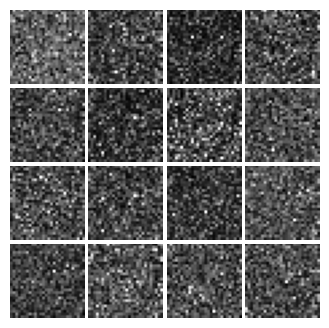

In [ ]:
# 开始训练
for it in range(1000000):
    for _, (real_img, _) in enumerate(dloader):
        N, C, H, W = real_img.size()

        # ------------------------------ 1. 训练判别器 D ------------------------------
        real_img = Variable(real_img.view(-1, X_dim))

        # 生成噪声
        z = Variable(torch.randn(mb_size, z_dim))

        # 判别器前向传播
        G_sample = G(z)
        D_real = D(real_img)
        D_fake = D(G_sample)

        # 计算损失
        D_loss = -(torch.mean(-torch.exp(D_real)) - torch.mean(-1 - D_fake))

        # 反向传播和更新判别器参数
        D_loss.backward()
        D_solver.step()
        reset_grad()

        # ------------------------------ 2. 训练生成器 G ------------------------------

        # 生成噪声
        z = Variable(torch.randn(mb_size, z_dim))

        # 生成器前向传播
        G_sample = G(z)
        D_fake = D(G_sample)

        # 计算生成器损失
        G_loss = -torch.mean(-1 - D_fake)

        # 反向传播和更新生成器参数
        G_loss.backward()
        G_solver.step()
        reset_grad()

    # 打印和绘制图像
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}'.format(it, D_loss.item(), G_loss.item()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        plt.show()
        file_name += 1
        plt.close(fig)